In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import statsmodels.api as sm
import admix
from scipy.stats import pearsonr
import matplotlib
from tqdm import tqdm
from typing import List, Dict
import calpgs

matplotlib.rcParams["font.family"] = ["Liberation Sans"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [20]:
# CONSTANTS
COVAR_COLS = ["AGE", "SEX", "DEPRIVATION_INDEX"] + [f"PC{i}" for i in range(1, 11)]
DATA_DIR = "/u/project/pasaniuc/pasaniucdata/admixture/projects/calprs/experiments/compile-data/out"
PHENO_DIR = "/u/project/sgss/UKBB/PRS-RESEARCH/03-compile-pheno/out"

MAIN_TRAIT_LIST = [
    "log_monocyte",
    "log_leukocyte",
    "log_CRP",
    "log_triglycerides",
    "LDL",
    "log_SHBG",
    "systolic_BP",
    "diastolic_BP",
    "FEV1",
    "log_heel_BMD",
    "height",
    "years_of_edu",
    "neuroticism",
]


def load_trait_info(
    trait: str, indiv_group: str, covar_cols: List[str]
) -> pd.DataFrame:
    """
    Load
    (1) trait values PHENO_DIR/{trait}.tsv
    (2) polygenic score DATA_DIR/pred/{trait}.score_summary.tsv.gz
    (3) covariates DATA_DIR/covar.tsv
    (3) covariates to adjust for, e.g., age, sex, top 10 PCs
    (4) covariate to test

    Parameters
    ----------
    trait: str
        trait name
    indiv_group: str
        "white_british" or "other"
    covar_cols: List[str]
        list of covariates to load from covar file
    """

    ## 1. load trait and score
    df_trait = pd.read_csv(
        os.path.join(PHENO_DIR, f"{trait}.tsv"), sep="\t", index_col=0
    ).drop(columns=["IID"])

    df_score = pd.read_csv(
        os.path.join(DATA_DIR, f"pred/{trait}.score_summary.tsv.gz"),
        sep="\t",
        index_col=0,
    )
    df_score.index = [int(i.split("_")[0]) for i in df_score.index]

    ## 2. load covariates
    df_covar = pd.read_csv(os.path.join(DATA_DIR, "covar.tsv"), sep="\t", index_col=0)

    # add some phenotype to the covariates
    for col in covar_cols:
        if col in df_covar.columns:
            continue
        else:
            tmp_path = os.path.join(PHENO_DIR, f"{col}.tsv")
            if os.path.exists(tmp_path):
                df_tmp = pd.read_csv(tmp_path, sep="\t", index_col=0).drop(
                    columns=["IID"]
                )
                df_covar[col] = df_tmp["PHENO"].reindex(df_covar.index)
            else:
                warnings.warn(f"{tmp_path} does not exist")

    # merge all files together
    df_trait = pd.merge(df_score, df_trait, left_index=True, right_index=True)
    df_trait = pd.merge(df_trait, df_covar, left_index=True, right_index=True)

    # restricted to indiv_group
    if indiv_group == "white_british":
        df_trait = df_trait[df_trait.group == "United Kingdom"]
    elif indiv_group == "other":
        df_trait = df_trait[~(df_trait.group == "United Kingdom")]
    df_trait = df_trait.dropna()

    return df_trait

In [21]:
# TODO: check the missing data in these columns, in case many individuals get filled out.

In [22]:
TEST_COLS = ["SEX", "glasses"] + [
    "AGE",
    "years_of_edu",
    "income",
    "DEPRIVATION_INDEX",
    "PC1",
    "PC2",
]

print("Covariates:", ", ".join(COVAR_COLS))
print("Testing:", ", ".join(TEST_COLS))

Covariates: AGE, SEX, DEPRIVATION_INDEX, PC1, PC2, PC3, PC4, PC5, PC6, PC7, PC8, PC9, PC10
Testing: SEX, glasses, AGE, years_of_edu, income, DEPRIVATION_INDEX, PC1, PC2


In [27]:
def load_trait_r2_coverage(
    trait: str, indiv_group: str, test_cols: List[str], adjust_cols: List[str]
):
    """
    Calculate trait R2 coverage.

    Parameters
    ----------
    trait: str
        trait of interest
    indiv_group: str
        group of individuals
    test_cols: List[str]
        which columns to calculate the R2 coverage
    adjust_cols: List[str]
        which columns used to adjustment
    """
    np.random.seed(1234)

    df_trait = load_trait_info(
        trait=trait, indiv_group=indiv_group, covar_cols=COVAR_COLS
    )
    df_trait["PHENO_RESID"] = (
        sm.OLS(
            df_trait["PHENO"].values,
            sm.add_constant(df_trait[COVAR_COLS]),
            missing="drop",
        )
        .fit()
        .resid
    )

    ## convert all columns to categorical columns when appropriate
    cat_test_cols = []
    for col in test_cols:
        n_unique = len(np.unique(df_trait[col].values))
        if n_unique > 5:
            df_trait[col + "_Q"] = pd.qcut(
                df_trait[col], q=5, duplicates="drop"
            ).cat.codes
            print(f"Converting column '{col}' to 5 quintiles")
            cat_test_cols.append(col + "_Q")
        else:
            cat_test_cols.append(col)

    ## calculate R2
    dict_r2 = {}
    for col in cat_test_cols:
        dict_r2[col] = calprs.summarize_pred(
            df_trait,
            y_col="PHENO_RESID",
            pred_col="MEAN",
            group_col=col,
            n_bootstrap=1000,
            return_r2_diff=True,
        )

    return dict_r2
    ## calculate coverage after overall adjustment
    dict_cov = {col: [] for col in [None] + cat_test_cols}

    for repeat_i in tqdm(range(100)):
        calibrate_idx = np.random.choice(
            df_trait.index, size=int(len(df_trait) * 0.1), replace=False
        ).tolist()
        test_idx = list(set(df_trait.index) - set(calibrate_idx))

        # perform calibration
        df_calibrated = calprs.calibrate_pred(
            df_trait,
            y_col="PHENO_RESID",
            pred_col="MEAN",
            predstd_col="SD",
            calibrate_idx=calibrate_idx,
            ci_method="scale",
            ci=0.9,
        ).loc[test_idx, :]

        for col in ["PHENO_RESID"] + cat_test_cols:
            df_calibrated[col] = df_trait[col].reindex(df_calibrated.index)
        for col in dict_cov:
            dict_cov[col].append(
                calprs.summarize_pred(
                    df_calibrated,
                    y_col="PHENO_RESID",
                    pred_col="MEAN",
                    predstd_col="SD",
                    group_col=col,
                )
            )

    ## calculate coverage after adjust for both AGE and SEX
    dict_cov2 = {col: [] for col in [None] + cat_test_cols}

    for repeat_i in tqdm(range(100)):
        calibrate_idx = np.random.choice(
            df_trait.index, size=int(len(df_trait) * 0.1), replace=False
        ).tolist()
        test_idx = list(set(df_trait.index) - set(calibrate_idx))

        # perform calibration
        df_calibrated = calprs.calibrate_pred(
            df_trait,
            y_col="PHENO_RESID",
            pred_col="MEAN",
            predstd_col="SD",
            calibrate_idx=calibrate_idx,
            ci_method="scale",
            ci=0.9,
            ci_adjust_cols=adjust_cols,
        ).loc[test_idx, :]

        for col in ["PHENO_RESID"] + cat_test_cols:
            df_calibrated[col] = df_trait[col].reindex(df_calibrated.index)
        for col in dict_cov2:
            dict_cov2[col].append(
                calprs.summarize_pred(
                    df_calibrated,
                    y_col="PHENO_RESID",
                    pred_col="MEAN",
                    predstd_col="SD",
                    group_col=col,
                )
            )

    return dict_r2, dict_cov, dict_cov2

In [28]:
dict_r2 = load_trait_r2_coverage(
    "LDL", "white_british", ["AGE", "SEX", "PC1", "PC2"], ["AGE", "SEX", "PC1", "PC2"]
)

Converting column 'AGE' to 5 quintiles
Converting column 'PC1' to 5 quintiles
Converting column 'PC2' to 5 quintiles


Bootstrapping: 100%|██████████| 1000/1000 [00:14<00:00, 71.42it/s]


In [ ]:
dict_r2, dict_cov1, dict_cov2 = load_trait_r2_coverage(
    "LDL", "white_british", ["AGE", "SEX", "PC1", "PC2"], ["AGE", "SEX", "PC1", "PC2"]
)

/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Converting column 'AGE' to 5 quintiles
Converting column 'PC1' to 5 quintiles
Converting column 'PC2' to 5 quintiles


  9%|▉         | 9/100 [00:20<03:08,  2.07s/it]/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 35%|███▌      | 35/100 [01:56<03:51,  3.55s/it]/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 61%|██████    | 61/100 [03:18<01:17,  1.99s/it]/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 73%|███████▎  | 73/100 [03:54<00:56,  2.11s/it]/u/project/pasaniuc/

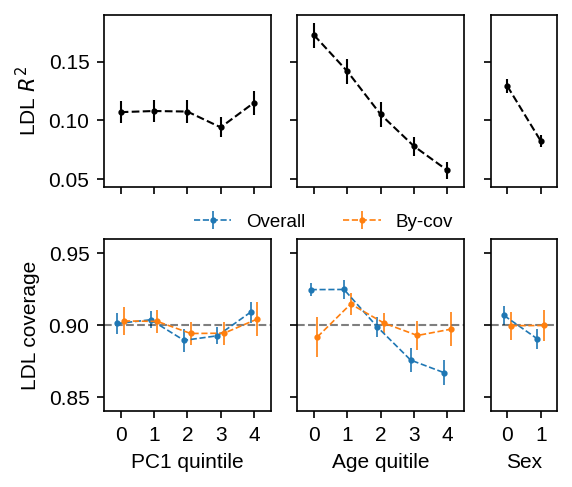

In [23]:
dict_r2, dict_cov1, dict_cov2 = load_trait_r2_coverage(
    "LDL", "white_british", ["AGE", "SEX", "PC1", "PC2"], ["AGE", "SEX", "PC1", "PC2"]
)
fig, axes = plot_figure(
    dict_r2,
    dict_cov1,
    dict_cov2,
    xlabels=["PC1_Q", "AGE_Q", "SEX"],
    xlabel_map={"PC1_Q": "PC1 quintile", "AGE_Q": "Age quitile", "SEX": "Sex"},
    trait="LDL",
    ylim_cov=[0.8, 0.9],
    #     ylim_r2=[0.04, 0.21],
)

handles, labels = axes[1, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="center",
    ncol=2,
    fontsize=9,
    bbox_to_anchor=[0.5, 0.485],
    frameon=False,
)
fig.subplots_adjust(hspace=0.3)
fig.savefig("results/ldl.white.pdf", bbox_inches="tight")

/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Converting column 'AGE' to 5 quintiles
Converting column 'PC1' to 5 quintiles
Converting column 'PC2' to 5 quintiles


 11%|█         | 11/100 [00:23<03:37,  2.44s/it]/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 47%|████▋     | 47/100 [01:51<01:31,  1.73s/it]/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 70%|███████   | 70/100 [03:02<00:53,  1.77s/it]/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
100%|██████████| 100/100 [04:37<00:00,  2.78s/it]


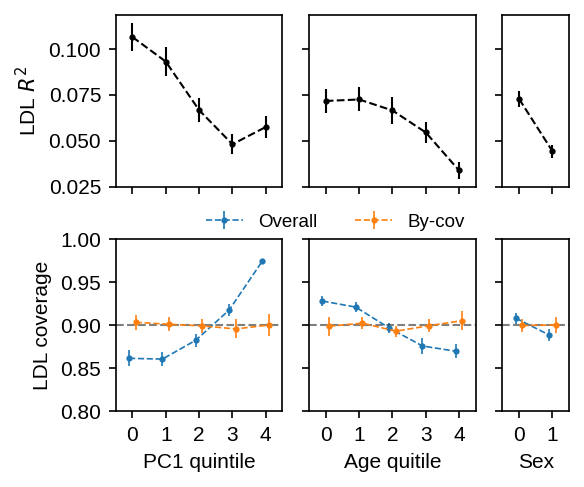

In [19]:
dict_r2, dict_cov1, dict_cov2 = load_trait_r2_coverage(
    "LDL", "other", ["AGE", "SEX", "PC1", "PC2"], ["AGE", "SEX", "PC1", "PC2"]
)

fig, axes = plot_figure(
    dict_r2,
    dict_cov1,
    dict_cov2,
    xlabels=["PC1_Q", "AGE_Q", "SEX"],
    xlabel_map={"PC1_Q": "PC1 quintile", "AGE_Q": "Age quitile", "SEX": "Sex"},
    trait="LDL",
    ylim_cov=[0.8, 1.0],
    #     ylim_r2=[0.04, 0.21],
)

handles, labels = axes[1, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="center",
    ncol=2,
    fontsize=9,
    bbox_to_anchor=[0.5, 0.485],
    frameon=False,
)
fig.subplots_adjust(hspace=0.3)
fig.savefig("results/ldl.nonwhite.pdf", bbox_inches="tight")

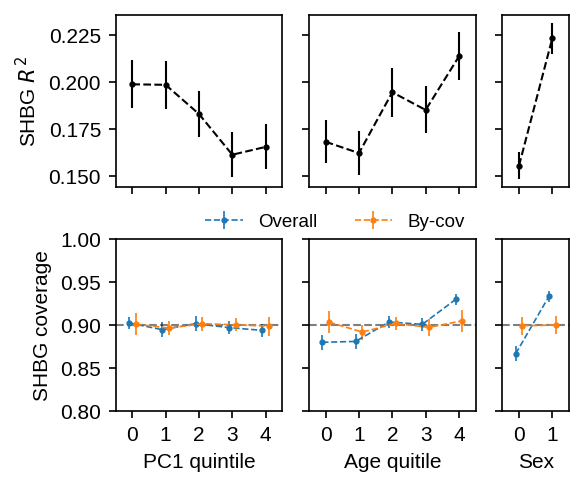

In [18]:
dict_r2, dict_cov1, dict_cov2 = load_trait_r2_coverage(
    "log_SHBG",
    "white_british",
    ["AGE", "SEX", "PC1", "PC2"],
    ["AGE", "SEX", "PC1", "PC2"],
)

fig, axes = plot_figure(
    dict_r2,
    dict_cov1,
    dict_cov2,
    xlabels=["PC1_Q", "AGE_Q", "SEX"],
    xlabel_map={"PC1_Q": "PC1 quintile", "AGE_Q": "Age quitile", "SEX": "Sex"},
    trait="SHBG",
    ylim_cov=[0.8, 1.0],
    #     ylim_r2=[0.04, 0.21],
)

handles, labels = axes[1, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="center",
    ncol=2,
    fontsize=9,
    bbox_to_anchor=[0.5, 0.485],
    frameon=False,
)
fig.subplots_adjust(hspace=0.3)

/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
 40%|████      | 40/100 [00:08<00:12,  4.68it/s]/u/project/pasaniuc/kangchen/software/miniconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


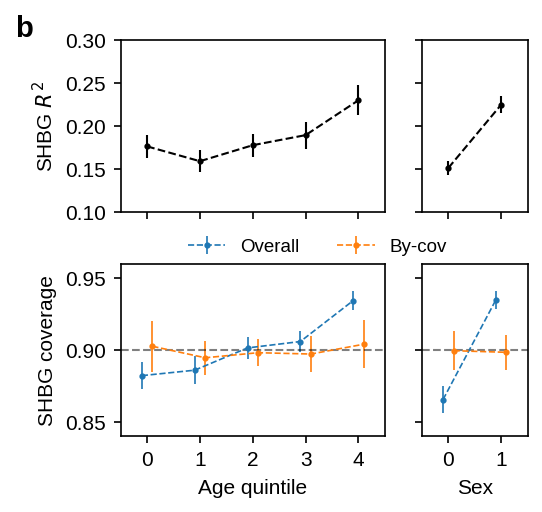

In [7]:
dict_r2, dict_cov1, dict_cov2 = load_trait_r2_coverage("log_SHBG")

fig, axes = plot_figure(
    dict_r2,
    dict_cov1,
    dict_cov2,
    trait="SHBG",
    ylim_r2=[0.1, 0.3],
    ylim_cov=[0.84, 0.96],
)
handles, labels = axes[1, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="center",
    ncol=2,
    fontsize=9,
    bbox_to_anchor=[0.5, 0.485],
    frameon=False,
)
plt.subplots_adjust(hspace=0.3)

axes[0, 0].text(
    -0.4,
    1.02,
    "b",
    transform=axes[0, 0].transAxes,
    size=14,
    weight="bold",
)
fig.savefig("results/shbg.pdf", bbox_inches="tight")